# **<center>Notebook: Memory for Surprise-driven Exploration (Atari Ver.)</center>**





















**Reference:**
1. Burda, Y., Edwards, H., Storkey, A., & Klimov, O. (2018). Exploration by random network distillation. arXiv preprint arXiv:1810.12894.
2. Pathak, D., Agrawal, P., Efros, A. A., & Darrell, T. (2017, July). Curiosity-driven exploration by self-supervised prediction. In International conference on machine learning (pp. 2778-2787). PMLR.
3. Huang, S., Dossa, R. F. J., Ye, C., Braga, J., Chakraborty, D., Mehta, K., & AraÃšjo, J. G. (2022). Cleanrl: High-quality single-file implementations of deep reinforcement learning algorithms. Journal of Machine Learning Research, 23(274), 1-18.
4. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. arXiv preprint arXiv:1606.01540.



In this notebook we present the implementation of method in the paper **"Exploration by random network distillation"**, which we refer to as RND intrinsic reward, and in the paper **"Curiosity-driven exploration by self-supervised prediction"**, which we refer to as ICM intrinsic reward.

## **1. Setting up the libraries** 

In [17]:
# Run these commands from the terminal to install related libraries and set up the working environment
# pip install gym # Install the gym library with RL environments
# pip install envpool
# pip install torch

In [18]:
import os, random, time
from collections import deque
from dataclasses import dataclass

import pandas as pd
import gym
# import gymnasium as gym
import numpy as np
import torch
import envpool

import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
from gym.wrappers.normalize import RunningMeanStd
import matplotlib.pyplot as plt


In [19]:
envpool.list_all_envs()             # envpool library supports creating a huge number of multi-process environments -> we will use this for our environnment today.

['Adventure-v5',
 'AirRaid-v5',
 'Alien-v5',
 'Amidar-v5',
 'Assault-v5',
 'Asterix-v5',
 'Asteroids-v5',
 'Atlantis-v5',
 'Atlantis2-v5',
 'Backgammon-v5',
 'BankHeist-v5',
 'BasicMath-v5',
 'BattleZone-v5',
 'BeamRider-v5',
 'Berzerk-v5',
 'Blackjack-v5',
 'Bowling-v5',
 'Boxing-v5',
 'Breakout-v5',
 'Carnival-v5',
 'Casino-v5',
 'Centipede-v5',
 'ChopperCommand-v5',
 'CrazyClimber-v5',
 'Crossbow-v5',
 'Darkchambers-v5',
 'Defender-v5',
 'DemonAttack-v5',
 'DonkeyKong-v5',
 'DoubleDunk-v5',
 'Earthworld-v5',
 'ElevatorAction-v5',
 'Enduro-v5',
 'Entombed-v5',
 'Et-v5',
 'FishingDerby-v5',
 'FlagCapture-v5',
 'Freeway-v5',
 'Frogger-v5',
 'Frostbite-v5',
 'Galaxian-v5',
 'Gopher-v5',
 'Gravitar-v5',
 'Hangman-v5',
 'HauntedHouse-v5',
 'Hero-v5',
 'HumanCannonball-v5',
 'IceHockey-v5',
 'Jamesbond-v5',
 'JourneyEscape-v5',
 'Kaboom-v5',
 'Kangaroo-v5',
 'KeystoneKapers-v5',
 'KingKong-v5',
 'Klax-v5',
 'Koolaid-v5',
 'Krull-v5',
 'KungFuMaster-v5',
 'LaserGates-v5',
 'LostLuggage-v5',

## **2. Introducing the Breakout Environment**

- 👋 We will use the simple Breakout-v5 environment (https://gymnasium.farama.org/environments/atari/breakout/) for demonstration. A classic Atari game. 🎮 
- The goal is to move the paddle and hit the ball into a brick wall. The wall can be break through and the ball can wreak it on the other side. 1 game has 5 lives. 
- The **observation space** can be "rgb", "grayscale" or "ram" image (in this notebook we use the "rgb" variant which is the hardest), it represents the portview of the agent. And, **action space** is Discrete(4) including action to move left or right 🔄, fire the ball, and action to do nothing.
- You will get point (**reward**) depending on the color of the brick that you break: 
  - Red - 7 points         
  - Orange - 7 points        
  - Yellow - 4 points
  - Green - 4 points       
  - Aqua - 1 point           
  - Blue - 1 point.
- This notebook can also be used for other atari game environments as well. 😊 All you need to do is change the env_id. 

<p align="center">
  <img src="https://gymnasium.farama.org/_images/breakout.gif" width="300" height="400">
</p>


## **3. Simple PPO** 

**If you only want to run the surprise motivation, please run until section 3.2.2 to initialize the parameters and PPO.**
- In this section, we will test a simple PPO algorithm on the BreakOut-v5 environment. 🕹️
- The implementation of PPO in this notebook is inspired by the implementation of PPO from CleanRL package. 📊
- The result of this algorithm will be presented at the end of the notebook. 📝

### **3.1 Parameters**

In [20]:
params = {'env_id': "Breakout-v5",
          'exp_name': "RND",
          'torch_deterministic': True,
          'cuda': True,
          'seed': 1,
          # Training parameters
          'num_envs': 8,                                        # number of multi-environments
          'num_steps': 128,                                     # number of steps running in each environments per rollout
          'num_minibatches': 4,                                 # number of minibatches
          'total_timesteps': 10000000,                            # total training timesteps
          'learning_rate': 1e-4,                                # learning_rate
          'anneal_lr': True,                                    # reducing learning rate during learning
          'num_iterations_obs_norm_init': 50,
          'gamma': 0.999,
          'int_gamma': 0.99,
          'gae_lambda': 0.95,
          'int_coef': 1.0,
          'ext_coef': 2.0,
          'update_epochs': 4,
          'update_proportion': 0.25,
          'clip_coef': 0.1,
          'norm_adv': True,
          'clip_vloss': True,
          'ent_coef': 0.001,
          'vf_coef': 0.5,
          'max_grad_norm': 0.5,
          'target_kl': None}

device = torch.device("cuda" if torch.cuda.is_available() and params["cuda"] else "cpu")

# Set seed.
random.seed(params["seed"])                                                 
np.random.seed(params["seed"])
torch.manual_seed(params["seed"])
torch.backends.cudnn.deterministic = params["torch_deterministic"]

### **3.2 Models**

#### **3.2.1 Utils**

In [21]:
class RecordEpisodeStatistics(gym.Wrapper):
    def __init__(self, env, deque_size=100):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.episode_returns = None
        self.episode_lengths = None

    def reset(self, **kwargs):
        observations = super().reset(**kwargs)
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        self.lives = np.zeros(self.num_envs, dtype=np.int32)
        self.returned_episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.returned_episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return observations

    def step(self, action):
        observations, rewards, dones, _, infos = super().step(action)
        self.episode_returns += infos["reward"]
        self.episode_lengths += 1
        self.returned_episode_returns[:] = self.episode_returns
        self.returned_episode_lengths[:] = self.episode_lengths
        self.episode_returns *= 1 - infos["terminated"]
        self.episode_lengths *= 1 - infos["terminated"]
        infos["r"] = self.returned_episode_returns
        infos["l"] = self.returned_episode_lengths
        return (observations, rewards, dones, infos)

In [22]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)                # Initialize layer weights according to orthogonal method.
    torch.nn.init.constant_(layer.bias, bias_const)             # Set the bias of the layer.
    return layer

#### **3.2.2 PPO Agent**

In [23]:
class PPOAgent(nn.Module):
    def __init__(self, envs, use_int_rews=False):
        super().__init__()
        self.use_int_rews = use_int_rews

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 448)),
            nn.ReLU(),
        )

        self.extra_layer = nn.Sequential(layer_init(nn.Linear(448, 448), std=0.1), nn.ReLU())

        self.actor = nn.Sequential(
            layer_init(nn.Linear(448, 448), std=0.01),
            nn.ReLU(),
            layer_init(nn.Linear(448, envs.single_action_space.n), std=0.01),
        )
        
        self.critic_ext = layer_init(nn.Linear(448, 1), std=0.01)
        self.critic_int = layer_init(nn.Linear(448, 1), std=0.01)

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        features = self.extra_layer(hidden)
        if action is None:
            action = probs.sample()
        if self.use_int_rews:                                           # If intrinsic reward is used
            return (action, probs.log_prob(action), probs.entropy(), self.critic_ext(features + hidden), self.critic_int(features + hidden),)
        else:                                                           # If intrinsic reward is not used
            return (action, probs.log_prob(action), probs.entropy(), self.critic_ext(features + hidden),)

    def get_value(self, x):
        hidden = self.network(x / 255.0)
        features = self.extra_layer(hidden)
        if self.use_int_rews:                                           # If intrinsic reward is used
            return self.critic_ext(features + hidden), self.critic_int(features + hidden)
        else:                                                           # If intrinsic reward is not used
            return self.critic_ext(features + hidden)



#### **3.2.3 Main Training Loop**

In [24]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"

envs = envpool.make(
    params["env_id"],
    env_type="gym",
    num_envs=params["num_envs"],
    episodic_life=True,
    reward_clip=True,
    seed=params["seed"],
    repeat_action_probability=0.25,
)

envs.num_envs = params["num_envs"]
envs.single_action_space = envs.action_space
print(f"The action space of the environment is {envs.single_action_space}")
envs.single_observation_space = envs.observation_space
print(f"The observation space of the environment is {envs.single_observation_space}")

envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

The action space of the environment is Discrete(4)
The observation space of the environment is Box(0, 255, (4, 84, 84), uint8)


In [25]:
# Set up agent and model
Agent = PPOAgent(envs, use_int_rews=False).to(device)
optimizer = optim.Adam(
    Agent.parameters(),
    lr=params["learning_rate"],
    eps=1e-5,
)

In [26]:
obs = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_observation_space.shape).to(device)  
actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   
logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
avg_returns = deque(maxlen=20)

batch_size = int(params["num_envs"] * params["num_steps"])                
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size                        


In [ ]:
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)
results_simple_PPO = {"global_step":[],
                      "return_value":[]}
tracking_global_step = 0

for iteration in range(1, num_iterations+1):
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr
    
    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done 

        with torch.no_grad():
            action, logprob, _, value = Agent.get_action_and_value(obs[step])
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        for idx, d in enumerate(done):
            # If done and no more live -> Get return
            if d and info["lives"][idx] == 0:
                avg_returns.append(info["r"][idx])
                epi_ret = np.average(avg_returns)
                print(
                    f"global_step={global_step}, episodic_return={info['r'][idx]}"
                )
                if global_step - tracking_global_step > 10000:
                    results_simple_PPO["global_step"].append(global_step)
                    results_simple_PPO["return_value"].append(info['r'][idx])
                    tracking_global_step = global_step

    # bootstrap value if not done
    with torch.no_grad():
        next_value = Agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + params["gamma"] * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + params["gamma"] * params["gae_lambda"] * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = Agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > params["clip_coef"]).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if params["clip_vloss"]:
                value_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -params["clip_coef"],
                    params["clip_coef"],
                )
                value_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                value_loss_max = torch.max(value_loss_unclipped, value_loss_clipped)
                value_loss = 0.5 * value_loss_max.mean()
            else:
                value_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"]

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(Agent.parameters(), params["max_grad_norm"])
            optimizer.step()

        if params["target_kl"] is not None and approx_kl > params["target_kl"]:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    print("SPS:", int(global_step / (time.time() - start_time)))




In [28]:
envs.close()


In [29]:
# torch.save(Agent, "pretrained_models/simple_ppo_for_suprised_atari.pth")


In [ ]:
# Load the saved PPO agent
# agent = torch.load("pretrained_models/simple_ppo_for_suprised_atari.pth")

In [30]:
# Extract data from results_simple_PPO
ppo_global_step = results_simple_PPO["global_step"]
ppo_return_value = results_simple_PPO["return_value"]


df_ppo = pd.DataFrame({'global_step': ppo_global_step, 'return_value': ppo_return_value})


df_ppo.to_csv('data/results_simple_ppo_atari.csv', index=False)

## **4. Random Network Distillation**

- In this section, we will test the Random Network Distillation algorithm on the BreakOut-v5 environment. 🕹️
- The result of this algorithm will be presented at the end of the notebook. 📝

### **4.1 Key Points**

- Prediction problem is randomly generated. This involves 2 NNs, fixed target network sets the prediction problem (find an embedding $f(O)$ for an observation) and predictor network trained on data collected (with the task to predict $\hat{f}(O)$) from the agent, minimizing MSE Loss $\text{MSE} = \| \hat{f}(x; \theta) - f(x) \|^{2}_2$.
- Prediction error is expected to be higher in novel state (suprise state) that the agent is not familiar with. 
- $R=R_E+R_I$, thus, $V=V_E+V_I$.
- Reward and Observation Normalization.

### **4.2 Models**

#### **4.2.1 RND Models**

In [31]:
class RNDModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size

        feature_output = 7 * 7 * 64

        # Prediction network
        self.predictor = nn.Sequential(
            layer_init(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(feature_output, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 512)),
        )

        # Target network
        self.target = nn.Sequential(
            layer_init(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)),
            nn.LeakyReLU(),
            layer_init(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)),
            nn.LeakyReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(feature_output, 512)),
        )

        # fixed the target network params
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, next_obs):
        target_feature = self.target(next_obs)
        predict_feature = self.predictor(next_obs)

        return predict_feature, target_feature

In [32]:
class MovingSumOfReward:
    def __init__(self, gamma):
        self.moving_sum_of_reward = None
        self.gamma = gamma

    def update(self, rews):
        if self.moving_sum_of_reward is None:
            self.moving_sum_of_reward = rews
        else:
            self.moving_sum_of_reward = self.moving_sum_of_reward * self.gamma + rews
        return self.moving_sum_of_reward

#### **4.2.2 Main Training Loop**

In [33]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"

envs = envpool.make(
    params["env_id"],
    env_type="gym",
    num_envs=params["num_envs"],
    episodic_life=True,
    reward_clip=True,
    seed=params["seed"],
    repeat_action_probability=0.25,
)

envs.num_envs = params["num_envs"]
envs.single_action_space = envs.action_space
print(f"The action space of the environment is {envs.single_action_space}")
envs.single_observation_space = envs.observation_space
print(f"The observation space of the environment is {envs.single_observation_space}")

envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"


The action space of the environment is Discrete(4)
The observation space of the environment is Box(0, 255, (4, 84, 84), uint8)


In [34]:
# Set up agent and model
Agent = PPOAgent(envs, use_int_rews=True).to(device)
rnd_model = RNDModel(4, envs.single_action_space.n).to(device)
combined_parameters = list(Agent.parameters()) + list(rnd_model.predictor.parameters())
optimizer = optim.Adam(
    combined_parameters,
    lr=params["learning_rate"],
    eps=1e-5,
)

rew_runnning_mean_std = RunningMeanStd()
obs_runnning_mean_std = RunningMeanStd(shape=(1, 1, 84, 84))            # normalizing observation
discounted_reward = MovingSumOfReward(params["int_gamma"])


In [35]:
obs = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_observation_space.shape).to(device)  # (128, 4, 4, 84, 84)
actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   # (128, 4) 
logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
surprise_rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
ext_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
int_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
avg_returns = deque(maxlen=20)

In [ ]:
batch_size = int(params["num_envs"] * params["num_steps"])                      # 4 * 128
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size                        # 20000000/(4*128) -> num iterations
global_step = 0
start_time = time.time()

next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)

results_RND = {"global_step":[],
                "return_value":[],
                "intrinsic_reward":[]}

tracking_global_step = 0

# This will be used later when normalizing the observations
print("Start to initialize observation normalization parameter.....")
next_ob = []
for step in range(params["num_steps"] * params["num_iterations_obs_norm_init"]):
    acs = np.random.randint(0, envs.single_action_space.n, size=(params["num_envs"]))
    s, r, d, _ = envs.step(acs)
    next_ob += s[:, 3, :, :].reshape([-1, 1, 84, 84]).tolist()

    if len(next_ob) % (params["num_steps"] * params["num_envs"]) == 0:
        next_ob = np.stack(next_ob)
        obs_runnning_mean_std.update(next_ob)
        next_ob = []
print("End to initialize...")

for iteration in range(1, num_iterations + 1):
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr

    # n-step rollouts
    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            value_ext, value_int = Agent.get_value(obs[step])                   # -> get the extrinsic and intrinsic value for current observation
            ext_values[step], int_values[step] = (
                value_ext.flatten(),
                value_int.flatten(),
            )
            action, logprob, _, _, _ = Agent.get_action_and_value(obs[step])

        actions[step] = action
        logprobs[step] = logprob

        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        # Normalize obs for rnd
        rnd_next_obs = (
                (
                    (next_obs[:, 3, :, :].reshape(params["num_envs"], 1, 84, 84) - torch.from_numpy(obs_runnning_mean_std.mean).to(device))
                    / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var).to(device))
                ).clip(-5, 5)
            ).float()
        
        # Get the target F(O) and predict \hat(F)(O) value from rnd model
        target_next_feature, predict_next_feature = rnd_model.target(rnd_next_obs), rnd_model.predictor(rnd_next_obs)

        # Calculate the surprise reward based on MSE
        surprise_rewards[step] = ((target_next_feature - predict_next_feature).pow(2).sum(1) / 2).data

        for idx, d in enumerate(done):
            # If done and no more live -> Get return
            if d and info["lives"][idx] == 0:
                avg_returns.append(info["r"][idx])
                epi_ret = np.average(avg_returns)
                print(
                    f"global_step={global_step}, episodic_return={info['r'][idx]}, surprise_reward={np.mean(surprise_rewards[step].cpu().numpy())}"
                )
                if global_step - tracking_global_step > 10000:
                    results_RND["global_step"].append(global_step)
                    results_RND["return_value"].append(info['r'][idx])
                    results_RND["intrinsic_reward"].append(np.mean(surprise_rewards[step].cpu().numpy()))
                    tracking_global_step = global_step

    # Calculate the discounted reward 
    surprise_reward_per_env = np.array(
        [discounted_reward.update(reward_per_step) for reward_per_step in surprise_rewards.cpu().data.numpy().T]
    )

    mean, std, count = (
        np.mean(surprise_reward_per_env),
        np.std(surprise_reward_per_env),
        len(surprise_reward_per_env),
    )
    
    rew_runnning_mean_std.update_from_moments(mean, std**2, count)

    # Normalize the curiousity_rewards based on the running_mean_std
    surprise_rewards /= np.sqrt(rew_runnning_mean_std.var)

    # Calculate value if not done
    with torch.no_grad():
        next_value_ext, next_value_int = Agent.get_value(next_obs)
        next_value_ext, next_value_int = next_value_ext.reshape(1, -1), next_value_int.reshape(1, -1)   # -> get next state values external & internal
        ext_advantages = torch.zeros_like(rewards, device=device)
        int_advantages = torch.zeros_like(surprise_rewards, device=device)
        ext_lastgaelam = 0
        int_lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                ext_nextnonterminal = 1.0 - next_done
                int_nextnonterminal = 1.0
                ext_nextvalues = next_value_ext
                int_nextvalues = next_value_int
            else:
                ext_nextnonterminal = 1.0 - dones[t + 1]
                int_nextnonterminal = 1.0
                ext_nextvalues = ext_values[t + 1]
                int_nextvalues = int_values[t + 1]
            ext_delta = rewards[t] + params["gamma"] * ext_nextvalues * ext_nextnonterminal - ext_values[t]
            int_delta = surprise_rewards[t] + params["int_gamma"] * int_nextvalues * int_nextnonterminal - int_values[t]
            ext_advantages[t] = ext_lastgaelam = (
                ext_delta + params["gamma"] * params["gae_lambda"] * ext_nextnonterminal * ext_lastgaelam
            )
            int_advantages[t] = int_lastgaelam = (
                int_delta + params["int_gamma"] * params["gae_lambda"] * int_nextnonterminal * int_lastgaelam
            )
        ext_returns = ext_advantages + ext_values
        int_returns = int_advantages + int_values

    # Collect batch data for optimization
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)
    b_ext_advantages = ext_advantages.reshape(-1)
    b_int_advantages = int_advantages.reshape(-1)
    b_ext_returns = ext_returns.reshape(-1)
    b_int_returns = int_returns.reshape(-1)
    b_ext_values = ext_values.reshape(-1)

    b_advantages = b_int_advantages * params["int_coef"] + b_ext_advantages * params["ext_coef"]

    obs_runnning_mean_std.update(b_obs[:, 3, :, :].reshape(-1, 1, 84, 84).cpu().numpy())

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)

    rnd_next_obs = (
        (
            (b_obs[:, 3, :, :].reshape(-1, 1, 84, 84) - torch.from_numpy(obs_runnning_mean_std.mean).to(device))
            / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var).to(device))
        ).clip(-5, 5)
    ).float()

    clipfracs = []
    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            # Forward_loss
            predict_next_state_feature, target_next_state_feature = rnd_model(rnd_next_obs[mb_inds])

            # Calculate the MSE loss in the forward prediction of the RND Model 
            forward_loss = F.mse_loss(
                predict_next_state_feature, target_next_state_feature.detach(), reduction="none"
            ).mean(-1)

            mask = torch.rand(len(forward_loss), device=device)
            mask = (mask < params["update_proportion"]).type(torch.FloatTensor).to(device)
            forward_loss = (forward_loss * mask).sum() / torch.max(
                mask.sum(), torch.tensor([1], device=device, dtype=torch.float32)
            )
            _, newlogprob, entropy, new_ext_values, new_int_values = Agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > params["clip_coef"]).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            new_ext_values, new_int_values = new_ext_values.view(-1), new_int_values.view(-1)
            if params["clip_vloss"]:
                ext_value_loss_unclipped = (new_ext_values - b_ext_returns[mb_inds]) ** 2
                ext_v_clipped = b_ext_values[mb_inds] + torch.clamp(
                    new_ext_values - b_ext_values[mb_inds],
                    -params["clip_coef"],
                params["clip_coef"],
                )
                ext_value_loss_clipped = (ext_v_clipped - b_ext_returns[mb_inds]) ** 2
                ext_value_loss_max = torch.max(ext_value_loss_unclipped, ext_value_loss_clipped)
                ext_value_loss = 0.5 * ext_value_loss_max.mean()
            else:
                ext_value_loss = 0.5 * ((new_ext_values - b_ext_returns[mb_inds]) ** 2).mean()

            int_value_loss = 0.5 * ((new_int_values - b_int_returns[mb_inds]) ** 2).mean()

            value_loss = ext_value_loss + int_value_loss
            entropy_loss = entropy.mean()
            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"] + forward_loss

            optimizer.zero_grad()
            loss.backward()
            if params["max_grad_norm"]:
                nn.utils.clip_grad_norm_(
                    combined_parameters,
                    params["max_grad_norm"],
                )
            optimizer.step()

        if params["target_kl"] is not None:
            if approx_kl > params["target_kl"]:
                break

    print("SPS:", int(global_step / (time.time() - start_time)))
  

In [37]:
envs.close()


In [38]:
# torch.save(Agent, "pretrained_models/ppo_for_RND_atari.pth")
# torch.save(rnd_model, "pretrained_models/rnd_atari.pth")


In [ ]:
# # Load the saved PPO agent
# agent = torch.load("pretrained_models/ppo_for_RND_atari.pth")
# # Load the saved ICM model
# icm = torch.load("pretrained_models/rnd_atari.pth")

In [39]:
# Extract data from results_RND
rnd_global_step = results_RND["global_step"]
rnd_return_value = results_RND["return_value"]
rnd_intrinsic_reward = results_RND["intrinsic_reward"]

df_rnd = pd.DataFrame({'global_step': rnd_global_step, 'return_value': rnd_return_value, 'intrinsic_reward': rnd_intrinsic_reward})
# Save DataFrames to CSV files
df_rnd.to_csv('data/results_rnd_atari.csv', index=False)



## **5. Curiosity-driven Exploration by Self-supervised Prediction**

- In this section, we will test the Intrinsic Curiousity Motivation (ICM) algorithm on the BreakOut-v5 environment. 🕹️
- The result of this algorithm will be presented at the end of the notebook. 📝

### **5.1 Key Points**


- The architecture is a network with two tasks, which we refer to as inverse prediction task and forward prediction task. The network, firstly, encodes the state $s_{t}$ and state $s_{t+1}$ into feature vectors $\phi(s_{t})$ and $\phi(s_{t+1})$. The network used the two encoded vectors as input to predict action $a_t$ in the inverse prediction task. It then used the result feature vectors $\phi(s_{t})$ and action $a_t$ as input to predict $\phi(s_{t+1})$. 
- The loss for the inverse prediction task is a cross entropy loss between the action chosen by the architecture and the real action that the agent has taken. The loss for the forward prediction task is an MSE loss.
- Prediction error is expected to be higher in novel state (suprise state) that the agent is not familiar with. 
- Reward and Observation Normalization.

<div style="text-align:center">
    <img src="./image/Curiousity-driven exploration.png" alt="AutoEncoder forr Count Based Exploration" width="420" height="350">
</div>

### **5.2 Models**


#### **5.2.1 ICM Models**

In [40]:
class ICMModel(nn.Module):
    def __init__(self, input_size, output_size, device, use_cuda=True):
        super(ICMModel, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.eta = 1.
        self.device = device

        feature_output = 7 * 7 * 64
        self.feature = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=8,
                stride=4),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(feature_output, 512)
        )

        self.inverse_net = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

        self.residual = [nn.Sequential(
            nn.Linear(output_size + 512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
        ).to(self.device)] * 4

        self.forward_net_1 = nn.Sequential(
            nn.Linear(output_size + 512, 512),
            nn.LeakyReLU()
        )
        self.forward_net_2 = nn.Sequential(
            nn.Linear(output_size + 512, 512),
        )

        for p in self.modules():
            if isinstance(p, nn.Conv2d):
                init.kaiming_uniform_(p.weight)
                p.bias.data.zero_()

            if isinstance(p, nn.Linear):
                init.kaiming_uniform_(p.weight, a=1.0)
                p.bias.data.zero_()

    def forward(self, inputs):
        state, next_state, action = inputs

        # We can the encoded value of current state and next state
        encode_state = self.feature(state)
        encode_next_state = self.feature(next_state)
        # We inverse predict the value of the action
        pred_action = torch.cat((encode_state, encode_next_state), 1)
        pred_action = self.inverse_net(pred_action)

        # Then we use the predicted action value to predict the encoded next state
        pred_next_state_feature_orig = torch.cat((encode_state, action), 1)
        pred_next_state_feature_orig = self.forward_net_1(pred_next_state_feature_orig)

        # residual
        for i in range(2):
            pred_next_state_feature = self.residual[i * 2](torch.cat((pred_next_state_feature_orig, action), 1))
            pred_next_state_feature_orig = self.residual[i * 2 + 1](
                torch.cat((pred_next_state_feature, action), 1)) + pred_next_state_feature_orig

        pred_next_state_feature = self.forward_net_2(torch.cat((pred_next_state_feature_orig, action), 1))

        real_next_state_feature = encode_next_state
        return real_next_state_feature, pred_next_state_feature, pred_action
    
    def compute_intrinsic_reward(self, state, next_state, action):
        action_onehot = torch.zeros(len(action), self.output_size, device=self.device)
        action_onehot.scatter_(1, action.view(len(action), -1), 1)

        real_next_state_feature, pred_next_state_feature, pred_action = self.forward([state, next_state, action_onehot])
        intrinsic_reward = self.eta * F.mse_loss(real_next_state_feature, pred_next_state_feature, reduction='none').mean(-1)
        return intrinsic_reward
    
    def inference(self, states, next_states, actions):
        action_onehot = torch.zeros(len(actions), self.output_size, device=self.device)
        action_onehot.scatter_(1, actions.view(-1, 1).long(), 1)

        real_next_state_feature, pred_next_state_feature, pred_action = self.forward([states, next_states, action_onehot])
        return real_next_state_feature, pred_next_state_feature, pred_action

In [41]:
class MovingSumOfReward:
    def __init__(self, gamma):
        self.moving_sum_of_reward = None
        self.gamma = gamma

    def update(self, rews):
        if self.moving_sum_of_reward is None:
            self.moving_sum_of_reward = rews
        else:
            self.moving_sum_of_reward = self.moving_sum_of_reward * self.gamma + rews
        return self.moving_sum_of_reward

#### **5.2.2 Main Training Loop**

In [42]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"

envs = envpool.make(
    params["env_id"],
    env_type="gym",
    num_envs=params["num_envs"],
    episodic_life=True,
    reward_clip=True,
    seed=params["seed"],
    repeat_action_probability=0.25,
)

envs.num_envs = params["num_envs"]
envs.single_action_space = envs.action_space
print(f"The action space of the environment is {envs.single_action_space}")
envs.single_observation_space = envs.observation_space
print(f"The observation space of the environment is {envs.single_observation_space}")

envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

The action space of the environment is Discrete(4)
The observation space of the environment is Box(0, 255, (4, 84, 84), uint8)


In [43]:
input_size = envs.single_observation_space
output_size = envs.single_action_space.n

is_load_model = False
is_render = False
use_cuda = params["cuda"]
use_gae = True
use_noisy_net = False
lam = params["gae_lambda"]
num_step = params["num_steps"]
learning_rate = params["learning_rate"]
entropy_coef = params["ent_coef"]
gamma = params["gamma"]
clip_grad_norm = params["max_grad_norm"]
pre_obs_norm_step = params["num_iterations_obs_norm_init"]

# Set up agent and model
icm = ICMModel(input_size, output_size, device).to(device)
Agent = PPOAgent(envs, use_int_rews=True).to(device)

combined_parameters = list(Agent.parameters() ) + list(icm.parameters())
optimizer = optim.Adam(
    combined_parameters,
    lr=params["learning_rate"],
    eps=1e-5,
)

rew_runnning_mean_std = RunningMeanStd()
obs_runnning_mean_std = RunningMeanStd(shape=(1, 1, 84, 84))            # normalizing observation
discounted_reward = MovingSumOfReward(params["int_gamma"])

In [44]:
obs = torch.zeros((params["num_steps"]+1, params["num_envs"]) + envs.single_observation_space.shape).to(device)  # (128, 4,, 4, 84, 84)


In [ ]:
batch_size = int(params["num_envs"] * params["num_steps"])                      # 4 * 128
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size                        # 20000000/(4*128) -> num iterations
global_step = 0
tracking_global_step = 0
start_time = time.time()

next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)

results_ICM = {"global_step":[],
                "return_value":[],
                "intrinsic_reward":[]}

print("Start to initialize observation normalization parameter.....")
next_ob = []
for step in range(params["num_steps"] * params["num_iterations_obs_norm_init"]):
    acs = np.random.randint(0, envs.single_action_space.n, size=(params["num_envs"]))
    s, r, d, _ = envs.step(acs)
    next_ob += s[:, 3, :, :].reshape([-1, 1, 84, 84]).tolist()

    if len(next_ob) % (params["num_steps"] * params["num_envs"]) == 0:
        next_ob = np.stack(next_ob)
        obs_runnning_mean_std.update(next_ob)
        next_ob = []
print("End to initialize...")

for iteration in range(1, num_iterations + 1):
    actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   # (128, 4) 
    logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    surprise_rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    ext_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    int_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    # Calculate the new learning rate as according to the annealing rate if needed.
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr

    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            value_ext, value_int = Agent.get_value(obs[step])                   # -> get the extrinsic and intrinsic value for current observation
            ext_values[step], int_values[step] = (
                value_ext.flatten(),
                value_int.flatten(),
            )
            action, logprob, _, _, _ = Agent.get_action_and_value(obs[step])
        
        actions[step] = action
        logprobs[step] = logprob        
        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        icm_obs = (                (
                    (obs[step][:, 3, :, :].reshape(params["num_envs"], 1, 84, 84).cpu() - torch.from_numpy(obs_runnning_mean_std.mean))
                    / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var))
                ).clip(-5, 5)
            ).float()
        icm_next_obs = (
                (
                    (next_obs[:, 3, :, :].reshape(params["num_envs"], 1, 84, 84).cpu() - torch.from_numpy(obs_runnning_mean_std.mean))
                    / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var))
                ).clip(-5, 5)
            ).float()
        
        surprise_rewards[step] = icm.compute_intrinsic_reward(icm_obs.to(device), icm_next_obs.to(device), actions[step].long())

        for idx, d in enumerate(done):
            # If done and no more live -> Get return
            if d and info["lives"][idx] == 0:
                print(
                    f"global_step={global_step}, episodic_return={info['r'][idx]}, surprise_reward={np.mean(surprise_rewards[step].data.cpu().numpy())}"
                )
                if global_step - tracking_global_step > 10000:
                    results_ICM["global_step"].append(global_step)
                    results_ICM["return_value"].append(info['r'][idx])
                    results_ICM["intrinsic_reward"].append(np.mean(surprise_rewards[step].data.cpu().numpy()))
                    tracking_global_step = global_step
            
    obs[-1] = next_obs

    # Calculate the discounted reward 
    surprise_reward_per_env = np.array(
        [discounted_reward.update(reward_per_step) for reward_per_step in surprise_rewards.cpu().data.numpy().T]
    )

    mean, std, count = (
        np.mean(surprise_reward_per_env),
        np.std(surprise_reward_per_env),
        len(surprise_reward_per_env),
    )
    
    rew_runnning_mean_std.update_from_moments(mean, std**2, count)

    # Normalize the curiousity_rewards based on the running_mean_std
    surprise_rewards /= np.sqrt(rew_runnning_mean_std.var)

    # Calculate value if not done
    with torch.no_grad():
        next_value_ext, next_value_int = Agent.get_value(next_obs)
        next_value_ext, next_value_int = next_value_ext.reshape(1, -1), next_value_int.reshape(1, -1)   # -> get next state values external & internal
        ext_advantages = torch.zeros_like(rewards, device=device)
        int_advantages = torch.zeros_like(surprise_rewards, device=device)
        ext_lastgaelam = 0
        int_lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                ext_nextnonterminal = 1.0 - next_done
                int_nextnonterminal = 1.0
                ext_nextvalues = next_value_ext
                int_nextvalues = next_value_int
            else:
                ext_nextnonterminal = 1.0 - dones[t + 1]
                int_nextnonterminal = 1.0
                ext_nextvalues = ext_values[t + 1]
                int_nextvalues = int_values[t + 1]
            ext_delta = rewards[t] + params["gamma"] * ext_nextvalues * ext_nextnonterminal - ext_values[t]
            int_delta = surprise_rewards[t] + params["int_gamma"] * int_nextvalues * int_nextnonterminal - int_values[t]
            ext_advantages[t] = ext_lastgaelam = (
                ext_delta + params["gamma"] * params["gae_lambda"] * ext_nextnonterminal * ext_lastgaelam
            )
            int_advantages[t] = int_lastgaelam = (
                int_delta + params["int_gamma"] * params["gae_lambda"] * int_nextnonterminal * int_lastgaelam
            )
        ext_returns = ext_advantages + ext_values
        int_returns = int_advantages + int_values
    
    # Collect batch data for optimization
    b_obs = obs[:-1].reshape((-1,) + envs.single_observation_space.shape)
    b_next_obs = obs[1:].reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)
    b_ext_advantages = ext_advantages.reshape(-1)
    b_int_advantages = int_advantages.reshape(-1)
    b_ext_returns = ext_returns.reshape(-1)
    b_int_returns = int_returns.reshape(-1)
    b_ext_values = ext_values.reshape(-1)

    b_advantages = b_int_advantages * params["int_coef"] + b_ext_advantages * params["ext_coef"]

    obs_runnning_mean_std.update(b_obs[:, 3, :, :].reshape(-1, 1, 84, 84).cpu().numpy())

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    icm_obs = (
        (
            (b_obs[:, 3, :, :].reshape(-1, 1, 84, 84).cpu() - torch.from_numpy(obs_runnning_mean_std.mean))
            / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var))
        ).clip(-5, 5)
    ).float()

    icm_next_obs = (
        (
            (b_next_obs[:, 3, :, :].reshape(-1, 1, 84, 84).cpu() - torch.from_numpy(obs_runnning_mean_std.mean))
            / torch.sqrt(torch.from_numpy(obs_runnning_mean_std.var))
        ).clip(-5, 5)
    ).float()

    ce = nn.CrossEntropyLoss()
    forward_mse = nn.MSELoss()

    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            real_next_state_feature, pred_next_state_feature, pred_action = icm.inference(icm_obs[mb_inds].to(device), icm_next_obs[mb_inds].to(device), b_actions[mb_inds])
            
            # Calculate the cross entropy loss of the action.
            inverse_loss = ce(
                    pred_action, b_actions[mb_inds].long())
            # Calculate the mse loss of the forward next state prediction.
            forward_loss = forward_mse(
                    pred_next_state_feature, real_next_state_feature.detach())

            _, newlogprob, entropy, new_ext_values, new_int_values = Agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            new_ext_values, new_int_values = new_ext_values.view(-1), new_int_values.view(-1)
            if params["clip_vloss"]:
                ext_value_loss_unclipped = (new_ext_values - b_ext_returns[mb_inds]) ** 2
                ext_v_clipped = b_ext_values[mb_inds] + torch.clamp(
                    new_ext_values - b_ext_values[mb_inds],
                    -params["clip_coef"],
                params["clip_coef"],
                )
                ext_value_loss_clipped = (ext_v_clipped - b_ext_returns[mb_inds]) ** 2
                ext_value_loss_max = torch.max(ext_value_loss_unclipped, ext_value_loss_clipped)
                ext_value_loss = 0.5 * ext_value_loss_max.mean()
            else:
                ext_value_loss = 0.5 * ((new_ext_values - b_ext_returns[mb_inds]) ** 2).mean()

            int_value_loss = 0.5 * ((new_int_values - b_int_returns[mb_inds]) ** 2).mean()

            value_loss = ext_value_loss + int_value_loss
            entropy_loss = entropy.mean()

            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"] + forward_loss + inverse_loss
        

            optimizer.zero_grad()
            loss.backward()
            if params["max_grad_norm"]:
                nn.utils.clip_grad_norm_(
                    combined_parameters,
                    params["max_grad_norm"],
                )
            optimizer.step()

    print("SPS:", int(global_step / (time.time() - start_time)))
       
    

In [46]:
envs.close()


In [47]:
# torch.save(Agent, "pretrained_models/ppo_for_ICM_atari.pth")
# torch.save(icm, "pretrained_models/icm_atari.pth")


In [ ]:
# # Load the saved PPO agent
# agent = torch.load("pretrained_models/ppo_for_ICM_atari.pth")
# # Load the saved ICM model
# icm = torch.load("pretrained_models/icm_atari.pth")

In [48]:
# Extract data from results_RND
icm_global_step = results_ICM["global_step"]
icm_return_value = results_ICM["return_value"]
icm_intrinsic_reward = results_ICM["intrinsic_reward"]

df_icm = pd.DataFrame({'global_step': icm_global_step, 'return_value': icm_return_value, 'intrinsic_reward': icm_intrinsic_reward})
# Save DataFrames to CSV files
df_icm.to_csv('data/results_icm_atari.csv', index=False)



## **6. Results Visualization**

In [50]:
df_simple_PPO = pd.read_csv('data/results_simple_ppo_atari.csv')
df_rnd = pd.read_csv('data/results_rnd_atari.csv')
df_icm = pd.read_csv('data/results_icm_atari.csv')

In [51]:
dfs = [df_simple_PPO, df_rnd, df_icm]

for df in dfs:
    df["return_value_smoothed"] = df["return_value"].ewm(alpha=1-0.9).mean()

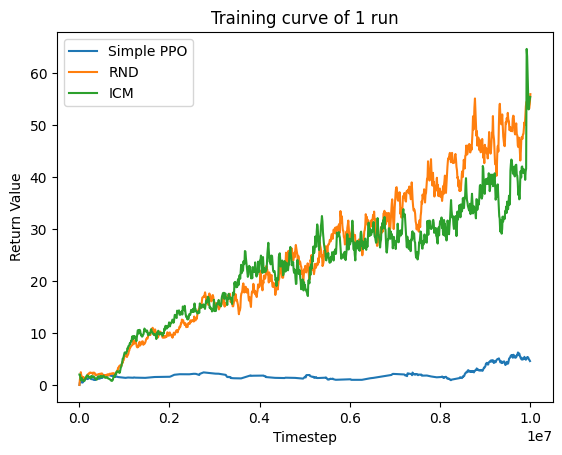

In [55]:
# Plot the data
plt.plot(df_simple_PPO["global_step"], df_simple_PPO["return_value_smoothed"], label='Simple PPO')
plt.plot(df_rnd["global_step"], df_rnd["return_value_smoothed"], label='RND')
plt.plot(df_icm["global_step"], df_icm["return_value_smoothed"], label='ICM')
plt.xlabel('Timestep')
plt.ylabel('Return Value')
plt.title('Training curve of 1 run')
plt.legend()
plt.show()

- In this scenario, it's evident that the returns obtained from using simple PPO show only marginal improvement over the course of 10,000,000 training timesteps on the Breakout-v5 environment.
- Conversely, RND and ICM exhibit significant improvements, with PPO emerging as the most effective method. This observation contrasts with the learning curve observed on the simpler CartPole-v1 environment. We attribute this difference to the increased difficulty of Breakout-v5, which necessitates thorough exploration of observations.
- While the substantial gap between PPO and the other two methods isn't always consistent (here we present the results of only one run), PPO often encounters failures. This underscores the necessity for exploration enhancement methods.